# Import libraries

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import joblib

import time
import os

# Import Data

In [13]:
# Direct path to file - update as needed 
file_df_57_large='/Users/ze/Desktop/Sample Data/v5_20240204_150730_57m.csv'

# Create dataframe from filepath 
df_57_large=pd.read_csv(file_df_57_large)

In [14]:
# current df to work on
df=df_57_large

In [15]:
# Verify 
df

Timestamp  accelX(g)  accelY(g)  accelZ(g)  \
0       04-Feb-2024 15:07:30.572    -0.0191    -0.4553    -0.9112   
1       04-Feb-2024 15:07:30.575    -0.0191    -0.4553    -0.9112   
2       04-Feb-2024 15:07:30.582    -0.0027    -0.4305    -0.8996   
3       04-Feb-2024 15:07:30.592    -0.0030    -0.4267    -0.8973   
4       04-Feb-2024 15:07:30.602    -0.0046    -0.4072    -0.8952   
...                          ...        ...        ...        ...   
345685  04-Feb-2024 16:04:57.613     0.0346    -0.5518    -0.7243   
345686  04-Feb-2024 16:04:57.619     0.0026    -0.5500    -0.5914   
345687  04-Feb-2024 16:04:57.630     0.0788    -0.6438    -0.6453   
345688  04-Feb-2024 16:04:57.639     0.1110    -0.6276    -0.7624   
345689  04-Feb-2024 16:04:57.649     0.0956    -0.6038    -0.8116   

        accelUserX(g)  accelUserY(g)  accelUserZ(g)  gyroX(rad/s)  \
0             -0.0046        -0.0283        -0.0133        0.1608   
1             -0.0046        -0.0283        -0.0133        0.1608   
2             -0.0089        -0.0148        -0.0070        0.1120   
3              0.0086         0.0063         0.0021        0.0393   
4              0.0053         0.0094         0.0032       -0.0469   
...               ...            ...            ...           ...   
345685        -0.0149         0.0409         0.1386        0.6348   
345686        -0.0173         0.0426         0.1373        0.6348   
345687         0.0544        -0.0799         0.1444       -0.0427   
345688         0.0539        -0.0805         0.1447       -0.2525   
345689         0.0498        -0.0404         0.0103       -0.4047   

        gyroY(rad/s)  gyroZ(rad/s)  ...  ActivityType  ActivityConfidence  \
0            -0.2703       -0.1166  ...       Unknown                 Low   
1            -0.2703       -0.1166  ...       Unknown                 Low   
2            -0.2562       -0.0854  ...       Unknown                 Low   
3            -0.1595       -0.0719  ...       Unknown                 Low   
4            -0.0655       -0.0664  ...       Unknown                 Low   
...              ...           ...  ...           ...                 ...   
345685        0.5566       -0.0254  ...       Unknown                 Low   
345686        0.5566       -0.0254  ...       Unknown                 Low   
345687        0.3408        0.0716  ...       Unknown                 Low   
345688       -0.0424        0.0332  ...       Unknown                 Low   
345689       -0.3681        0.0009  ...       Unknown                 Low   

        Pressure(kilopascals)  RelativeAltitude(meters)  magX(µT)  magY(µT)  \
0                     92.0526                   -0.0106  602.5664  -90.8178   
1                     92.0526                   -0.0106  602.4935  -90.9008   
2                     92.0526                   -0.0106  602.4935  -90.9008   
3                     92.0526                   -0.0106  602.4935  -90.9008   
4                     92.0526                   -0.0106  602.4935  -90.9008   
...                       ...                       ...       ...       ...   
345685                92.0349                    1.5801  608.7485  -89.8198   
345686                92.0349                    1.5801  609.1280  -90.3697   
345687                92.0349                    1.5801  609.1280  -90.3697   
345688                92.0349                    1.5801  609.1280  -90.3697   
345689                92.0349                    1.5801  609.1280  -90.3697   

        magZ(µT)  calMagX(µT)  calMagY(µT)  calMagZ(µT)  
0      -263.3469      19.3366     -30.1109     -32.1170  
1      -263.2549      19.3366     -30.1109     -32.1170  
2      -263.2549      19.2643     -30.1139     -32.0779  
3      -263.2549      19.2943     -30.0041     -32.2354  
4      -263.2549      19.2432     -30.1386     -32.3034  
...          ...          ...          ...          ...  
345685 -266.0486      25.4797     -29.4161     -34.4778  
345686 -265.4232      25.75

# Helper functions

In [16]:
def convert_datetime(df):

    # Convert 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ns')

    return df

In [17]:
def reduce_sampling_rate(df):
    df.set_index('Timestamp', inplace=True)
    # Set the 'Timestamp' column as the DataFrame's index
    df_resampled = df.resample('S').first()
    # Reset the index to create a standard numerical index
    df_resampled.reset_index(inplace=True)
    return df_resampled

In [18]:
def plot_total_alt_over_time(df, plot_title='Total Tracked Altitude Over Time'):

    # Create the scatter plot using Plotly Express
    fig = px.scatter(df,
                     x=df['Timestamp'],
                     y=df['Alt(m)'])

    # Update the layout with title and axis labels
    fig.update_layout(
            title='Altitude over Time',
            xaxis_title='Timestamp',
            yaxis_title='Altitude (m)',
            coloraxis_colorbar=dict(title='Cluster Label'),
            width=1000,
            height=600
        )

    # Show the Plotly figure
    fig.show()

In [19]:
def plot_manual_labeling(df):
    # Plot for Altitude over Time, colored by 'on_lift' status
    plt.figure(figsize=(15, 10))

    # Plot points where 'on_lift' is 1 with one color
    plt.scatter(df.loc[df['on_lift'] == 1, 'Timestamp'],
                df.loc[df['on_lift'] == 1, 'Alt(m)'],
                c='red',
                label='On the lift',
                marker='o')

    # Plot points where 'on_lift' is 0 with another color
    plt.scatter(df.loc[df['on_lift'] == 0, 'Timestamp'],
                df.loc[df['on_lift'] == 0, 'Alt(m)'],
                c='blue',
                label='Not on the lift',
                marker='o')

    plt.title('Labeled Data')
    plt.xlabel('Timestamp')
    plt.ylabel('Altitude (m)')
    plt.legend()
    plt.show()

In [20]:
def map_lift_rides(df):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(),
                  df['Long'].mean()]
    mymap = folium.Map(location=map_center, zoom_start=10)

    # Plot data points with on_lift type
    on_lift = df[df['on_lift'] == 1]
    for index, row in on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'],
                                      row['Long']],
                            radius=5,
                            color='red',
                            fill=True,
                            fill_color='red',
                            tooltip=str(row['Timestamp'])).add_to(mymap)

    # Plot data points with not_on_lift types
    not_on_lift = df[df['on_lift'] != 1]
    for index, row in not_on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'],
                                      row['Long']],
                            radius=5,
                            color='blue',
                            fill=True,
                            fill_color='blue',
                            tooltip=str(row['Timestamp'])).add_to(mymap)

    # Return the map object
    return mymap


In [37]:
#Map all tracked movement based on lat and long of GPS data

def map_tracked_movement(df, zoom_start=12):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(), df['Long'].mean()]
    movement_on_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Add CircleMarkers for each data point
    for index, row in df.iterrows():
        folium.CircleMarker(location=[
                            row['Lat'], 
                            row['Long']], 
                            radius=5, 
                            color='blue', 
                            fill=True, 
                            fill_color='blue').add_to(movement_on_map)

    # Display the map
    return movement_on_map

In [38]:
#Map only lifts rides

def map_lift_rides(df, column='on_lift', zoom_start=15):
    # Create a map centered on the mean latitude and longitude
    map_center = [df['Lat'].mean(), df['Long'].mean()]
    lift_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Plot data points with on_lift type
    on_lift = df[df[column] == 1]
    for _, row in on_lift.iterrows():
        folium.CircleMarker(location=[row['Lat'],
                                      row['Long']],
                                      radius=5,
                                      color='red',
                                      fill=True,
                                      fill_color='red',
                                      tooltip=str(row['Timestamp'])).add_to(lift_map)

    # Return the map object
    return lift_map

# Reduce sample size 

In [21]:
# Use helper function to convert 'Timestamp' column dytpe 
df=convert_datetime(df)
# Verify 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345690 entries, 0 to 345689
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Timestamp                 345690 non-null  datetime64[ns]
 1   accelX(g)                 345690 non-null  float64       
 2   accelY(g)                 345690 non-null  float64       
 3   accelZ(g)                 345690 non-null  float64       
 4   accelUserX(g)             345690 non-null  float64       
 5   accelUserY(g)             345690 non-null  float64       
 6   accelUserZ(g)             345690 non-null  float64       
 7   gyroX(rad/s)              345690 non-null  float64       
 8   gyroY(rad/s)              345690 non-null  float64       
 9   gyroZ(rad/s)              345690 non-null  float64       
 10  Roll(rads)                345690 non-null  float64       
 11  Pitch(rads)               345690 non-null  float64       
 12  Ya

In [22]:
# Use helper function to resample to seconds  
df_resampled=reduce_sampling_rate(df)
# Verify 
print(f'Shape before resampling: {df.shape}')
print(f'Shape after resampling: {df_resampled.shape}\n')
df_resampled.info()

Shape before resampling: (345690, 43)
Shape after resampling: (3448, 44)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3448 entries, 0 to 3447
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 3448 non-null   datetime64[ns]
 1   accelX(g)                 3448 non-null   float64       
 2   accelY(g)                 3448 non-null   float64       
 3   accelZ(g)                 3448 non-null   float64       
 4   accelUserX(g)             3448 non-null   float64       
 5   accelUserY(g)             3448 non-null   float64       
 6   accelUserZ(g)             3448 non-null   float64       
 7   gyroX(rad/s)              3448 non-null   float64       
 8   gyroY(rad/s)              3448 non-null   float64       
 9   gyroZ(rad/s)              3448 non-null   float64       
 10  Roll(rads)                3448 non-null   float64       
 11  Pitch(ra

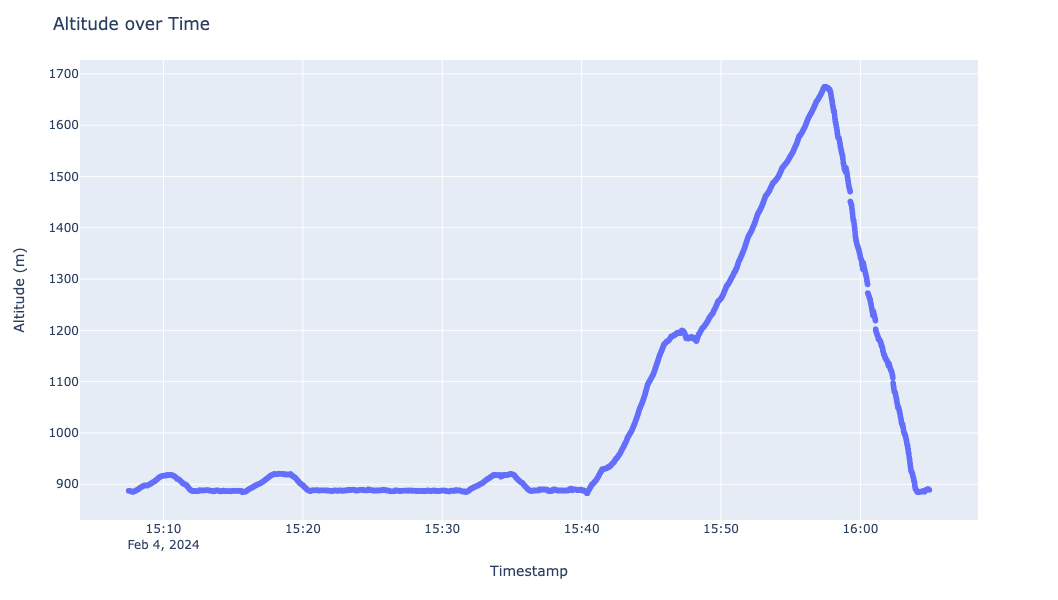

In [33]:
# Verify by plotting
plot_total_alt_over_time(df_resampled)

In [24]:
# If needed: Export resampled data frame to csv
name_of_csv_resampled='df_57_resampled.csv'
df_resampled.to_csv(name_of_csv_resampled, index=False)

# Label data to prepare df for supervised learning

In [27]:
# Assign dataframe that is yet to be labeled
df_to_be_labeled=df_resampled
initial_shape_df_to_be_labeled=df_to_be_labeled.shape
print(f'Initial shape: {initial_shape_df_to_be_labeled}')

Initial shape: (3448, 44)


In [28]:
# Check for missing values and drop rows with missing values
df_to_be_labeled.isnull().sum()

Timestamp                   0
accelX(g)                   0
accelY(g)                   0
accelZ(g)                   0
accelUserX(g)               0
accelUserY(g)               0
accelUserZ(g)               0
gyroX(rad/s)                0
gyroY(rad/s)                0
gyroZ(rad/s)                0
Roll(rads)                  0
Pitch(rads)                 0
Yaw(rads)                   0
m11                         0
m12                         0
m13                         0
m21                         0
m22                         0
m23                         0
m31                         0
m32                         0
m33                         0
qX                          0
qY                          0
qZ                          0
qW                          0
Lat                         0
Long                        0
Speed(m/s)                  0
TrueHeading                 0
Alt(m)                      0
HorizontalAccuracy(m)       0
VerticalAccuracy(m)         0
Course    

In [29]:
# Drop rows with any missing values
df_to_be_labeled.dropna(inplace=True)
print(f'Initial shape: {initial_shape_df_to_be_labeled}')
print(f'New shape: {df_to_be_labeled.shape}')

Initial shape: (3448, 44)
New shape: (3448, 44)


In [35]:
map_tracked_movement(df_to_be_labeled)

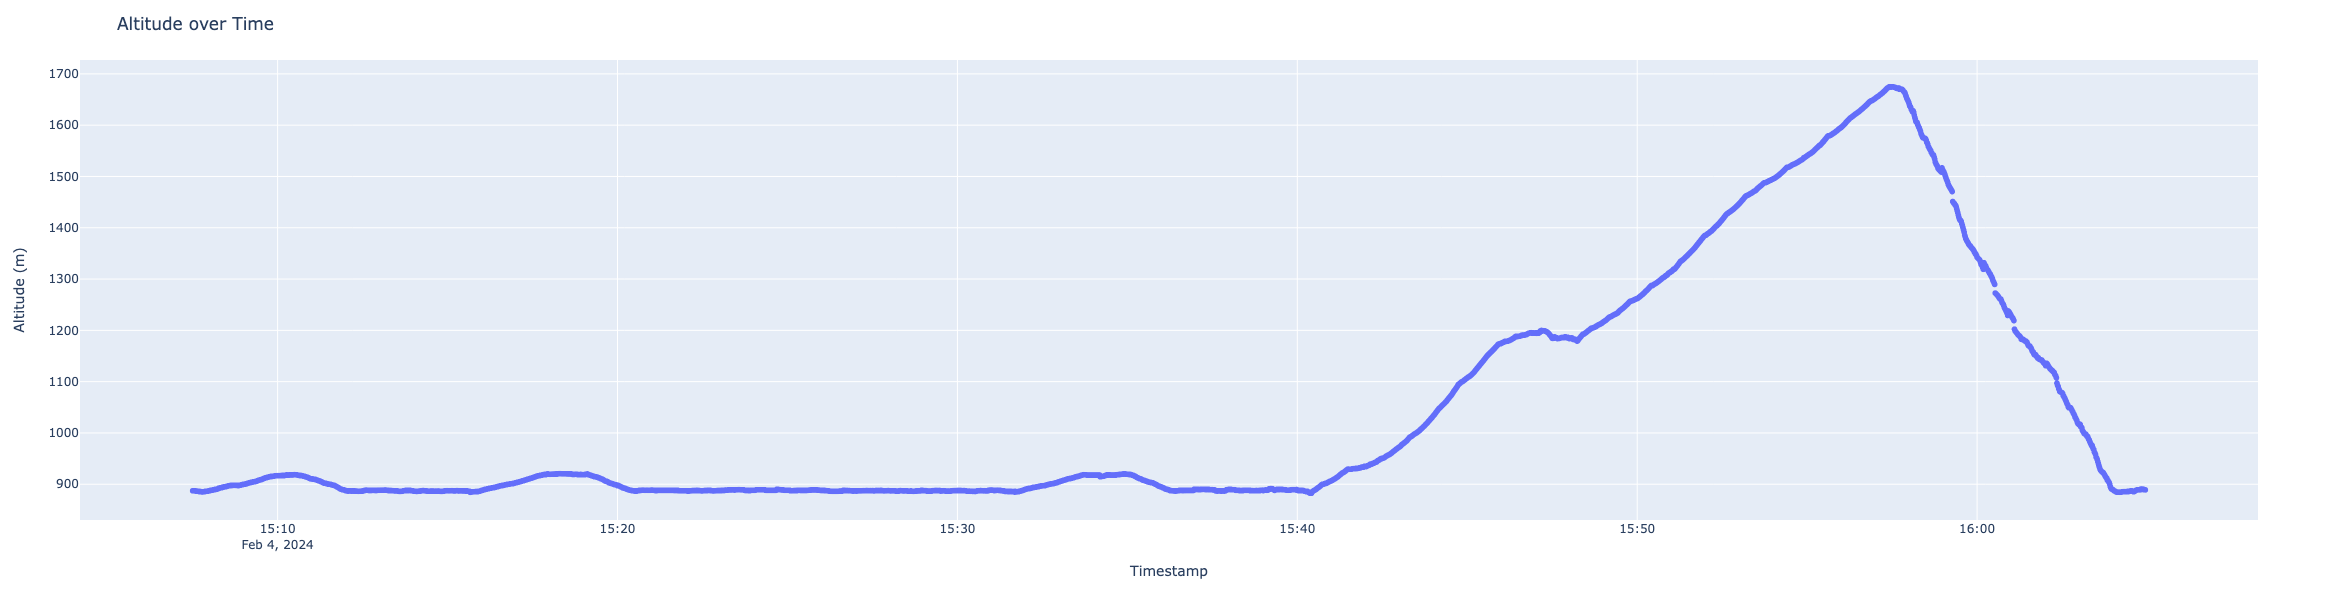

In [39]:
# Plot alt over time 
plot_total_alt_over_time(df_to_be_labeled)

# Get time stamps from hovering over plot 

In [73]:
# Add 'on_lift' column to df and set all values to 0
df_to_be_labeled['on_lift'] = 0

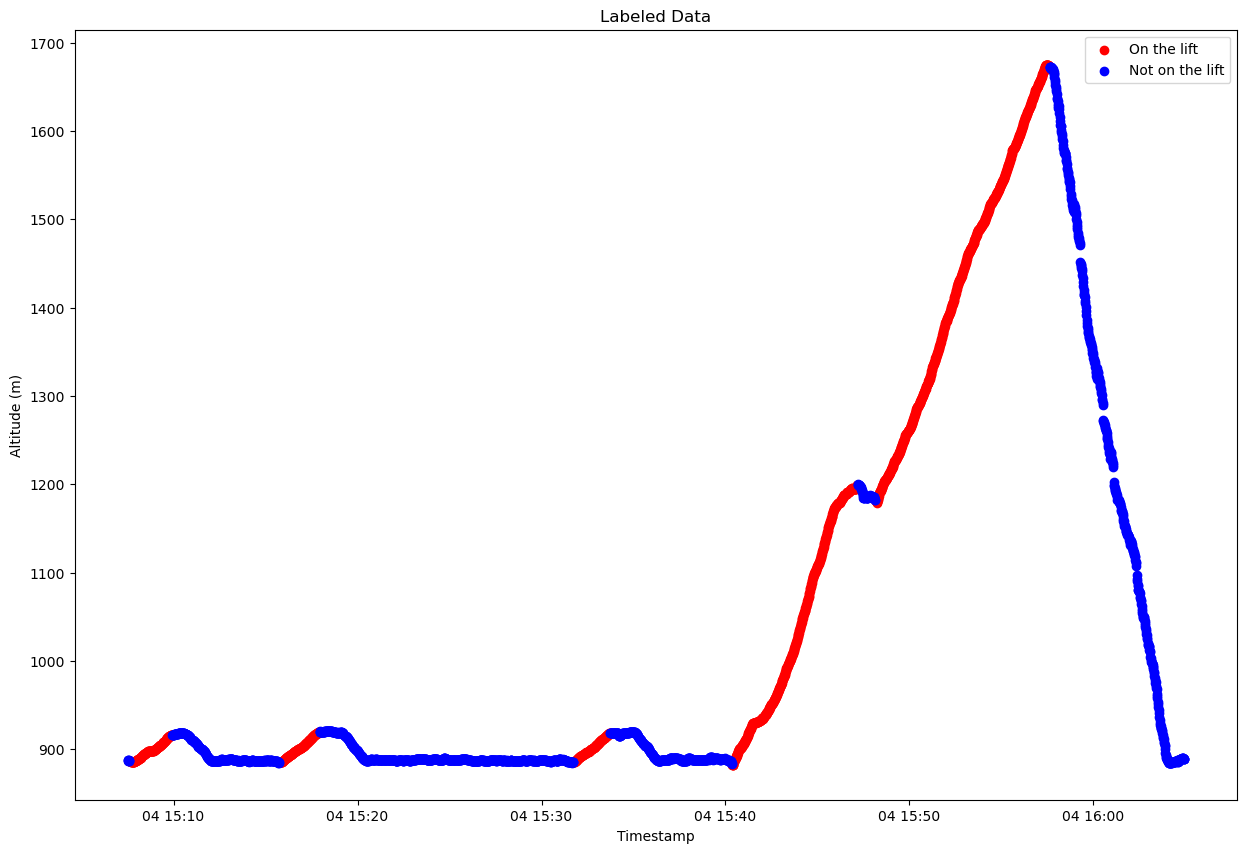

In [74]:
# Manually noted timestamps for lift rides
lift_rides = [
    ('2024-02-04 15:07:36', '2024-02-04 15:09:55'),
    ('2024-02-04 15:15:45', '2024-02-04 15:17:55'),
    ('2024-02-04 15:31:45', '2024-02-04 15:33:43'),
    ('2024-02-04 15:40:22', '2024-02-04 15:47:10'),
    ('2024-02-04 15:48:09', '2024-02-04 15:57:36'),
]

# Iterate and relabel df 
for start, end in lift_rides:
    # Update 'on_lift' column for rows where the timestamp falls within the lift ride's duration
    df_to_be_labeled.loc[(df_to_be_labeled['Timestamp'] >= start) & (df_to_be_labeled['Timestamp'] <= end), 'on_lift'] = 1

# Show plot with colored labels 
plot_manual_labeling(df_to_be_labeled)

# Show map with lift rides only 
lift_rides_map = map_lift_rides(df_to_be_labeled)
lift_rides_map

# Export

In [75]:
# export to CSV
name_of_csv_labeled='df_57_labeled.csv'
df_to_be_labeled.to_csv(name_of_csv_labeled, index=False)